In [1]:
import numpy as np
import matplotlib.pylab as plt
from skimage.feature import register_translation

In [2]:
from glob import glob

In [3]:
possible_path = glob('output/*/cube.npy')
print(possible_path)

['output/hpr1/cube.npy', 'output/HS2/cube.npy']


In [14]:
path = possible_path[1]
cube = np.load(path)
print(path, cube.shape)

output/HS2/cube.npy (1024, 1392, 24)


In [16]:
def get_shifts(I, J, x, y,
               window_half_size=15,
               upsample_factor=20):
    """
    Cross-correlation between images I and J,
    at the position (x, y) using a windows of size 2*window_half_size + 1

    see `register_translation` from skimage
    # https://scikit-image.org/docs/dev/api/skimage.feature.html#skimage.feature.register_translation
    """
    source = crop(I, (x, y), window_half_size)
    target = crop(J, (x, y), window_half_size)

    shifts, error, _ = register_translation(source, target,
                                            upsample_factor=upsample_factor)
    shifts = -shifts  # displacement = -registration = dst - src
    return shifts[1], shifts[0], error

In [18]:
def crop(I, ij_center, window_half_size):
    """Return the centered square at the position"""

    ij_center = np.around(ij_center).astype(np.int)
    i, j = ij_center
    i_slicing = np.s_[i - window_half_size:i + window_half_size + 1]
    j_slicing = np.s_[j - window_half_size:j + window_half_size + 1]

    return I[i_slicing, j_slicing]

In [19]:
ij_center = (10, 400)
window_half_size = 15
upsample_factor = 10

k = 3
I = crop(cube[:, :, k],   ij_center, window_half_size)
J = crop(cube[:, :, k+1], ij_center, window_half_size)

In [25]:
# 1-step traversal
def one_step_traversal(ij_center, window_half_size, upsample_factor):
    dx, dy = [], []
    xy = [ij_center, ]
    for k in range(cube.shape[2] - 1):
        ij_center_k = xy[-1]
        I = crop(cube[:, :, k],   ij_center_k, window_half_size)
        J = crop(cube[:, :, k+1], ij_center_k, window_half_size)

        if I.shape[0] != I.shape[1]:
            break
        shifts, error, _ = register_translation(I, J,
                                                upsample_factor=upsample_factor)
        dx.append(-shifts[0])
        dy.append(-shifts[1])
        xy.append( (ij_center_k[0] - shifts[0], ij_center_k[1] - shifts[1]) )

    dx = np.array(dx)
    dy = np.array(dy)

    x, y = zip(*xy)
    return (x, y), (dx, dy)

In [26]:
def build_grid(img_shape, margin, grid_spacing):
    """
    Build a regular grid
        img_shape from I.shape i.e. (Int, Int)
        margin in px
        grid_spacing in px
    """
    x_span = np.arange(margin, img_shape[1]-margin, grid_spacing)
    y_span = np.arange(margin, img_shape[0]-margin, grid_spacing)
    x_grid, y_grid = np.meshgrid(x_span, y_span)
  
    print("grid size:", "%ix%i" % (len(x_span), len(y_span)))
    print(" i.e.", len(x_span)*len(y_span), "points")

    return x_grid, y_grid

In [40]:
grid_x, grid_y = build_grid(cube.shape[:2], 50, 50)

grid size: 26x19
 i.e. 494 points


In [41]:
trajectories = []
displacements = []
for ij in zip(grid_x.flatten(), grid_y.flatten()):
    xy, dx = one_step_traversal(ij[::-1], window_half_size, upsample_factor)
    trajectories.append(xy)
    displacements.append(dx)
    print(f'{ij}', end='\r')

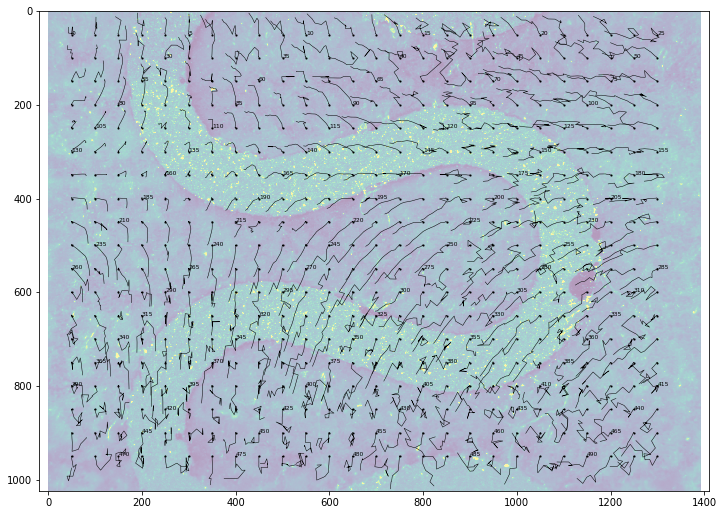

In [58]:
plt.figure(figsize=(12, 12*cube.shape[0]/cube.shape[1]));
plt.imshow(cube[:, :, 1], alpha=.4);
for k, (x, y) in enumerate(trajectories):
    plt.plot(y[0], x[0], 's', color='black', markersize=1)
    plt.plot(y, x, '-', linewidth=.5, markersize=2, color='black')
    if k % 5 == 0:
        plt.text(y[0], x[0], str(k), fontsize=6)
plt.axis('equal');

(0, 1392)

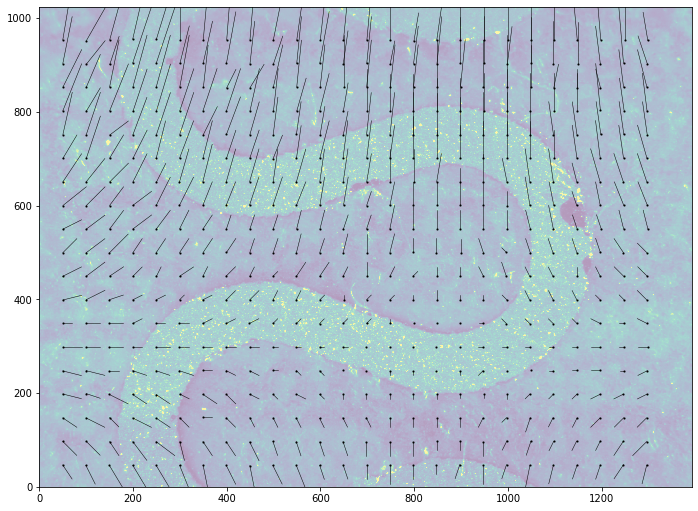

In [50]:
plt.figure(figsize=(12, 12*cube.shape[0]/cube.shape[1]));
plt.imshow(cube[:, :, 1], alpha=.4);

k = 9
show_factor = 100
for xy, dxy in zip(trajectories, displacements):
    x, y = xy
    dx, dy = dxy
    plt.plot(y[k], x[k], 's', color='black', markersize=1)
    plt.plot([y[k], y[k]+show_factor*dy[k]], [x[k], x[k]+show_factor*dx[k]],
             '-', linewidth=.5, markersize=2, color='black')
    
plt.ylim([0, cube.shape[0]])
plt.xlim([0, cube.shape[1]])

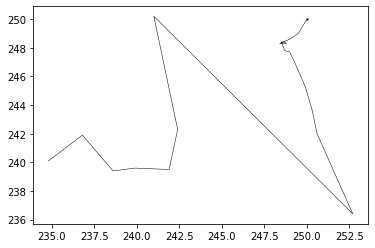

In [59]:
x, y = trajectories[108]
plt.plot(y[0], x[0], 's', color='black', markersize=1)
plt.plot(y, x, '-', linewidth=.5, markersize=2, color='black')